In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import re
import time
import os
from keras.preprocessing.sequence import pad_sequences
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Embedding, Bidirectional, concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from google.colab import drive

In [2]:
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
lines = open('/content/drive/My Drive/Colab Notebooks/Data/movie_lines.txt', encoding='utf-8', errors='ignore').read().split('\n')
conv_lines = open('/content/drive/My Drive/Colab Notebooks/Data/movie_conversations.txt', encoding='utf-8', errors='ignore').read().split('\n')

In [4]:
lines[:5]

['L1045 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ They do not!',
 'L1044 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ They do to!',
 'L985 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ I hope so.',
 'L984 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ She okay?',
 "L925 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Let's go."]

In [5]:
id2line = {}
for line in lines:
    _line = line.split(' +++$+++ ')
    if len(_line) == 5:
        id2line[_line[0]] = _line[4]

In [6]:
convs = []
for line in conv_lines[:-1]:
    _line = line.split(' +++$+++ ')[-1][1:-1].replace("'","").replace(" ","")
    convs.append(_line.split(','))

In [7]:
for k in convs[300]:
    print (k, id2line[k])

L3490 That's what he did to me.  He put cigarettes out on me.
L3491 Your father put cigarettes out on you?
L3492 Out on my back when I was a small boy.
L3493 Can I see your back?


In [8]:
# Sort the sentences into questions (inputs) and answers (targets)
questions = []
answers = []

for conv in convs:
    for i in range(len(conv)-1):
        questions.append(id2line[conv[i]])
        answers.append(id2line[conv[i+1]])

In [9]:
# Compare lengths of questions and answers
print(len(questions))
print(len(answers))

221616
221616


In [10]:
def clean_text(text):
    '''Clean text by removing unnecessary characters and altering the format of words.'''

    text = text.lower()

    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "that is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"how's", "how is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"n'", "ng", text)
    text = re.sub(r"'bout", "about", text)
    text = re.sub(r"'til", "until", text)
    text = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", text)
    text = " ".join(text.split())
    return text

In [11]:
clean_questions = []
for question in questions:
    clean_questions.append(clean_text(question))

clean_answers = []
for answer in answers:
    clean_answers.append(clean_text(answer))

In [12]:
r = np.random.randint(1,len(questions))
print ('original text......')
for i in range(r, r+3):
    print(questions[i])
    print(answers[i])
    print()
print ('cleaned text......')
for i in range(r, r+3):
    print(clean_questions[i])
    print(clean_answers[i])
    print()

original text......
That, that's <u>your</u> life's blood on the st...
I don't know what she's bitching about, she's flashed her tits in the last five movies...she'd bare her breasts to do a <u>voice</u> over.

I...
Get Mitch Cohn on the phone in New York, tell him she's breaking her contract and we're very up...

Get Mitch Cohn on the phone in New York, tell him she's breaking her contract and we're very up...
I...

cleaned text......
that that is uyouru life's blood on the st
i do not know what she is bitching about she is flashed her tits in the last five moviesshe would bare her breasts to do a uvoiceu over

i
get mitch cohn on the phone in new york tell him she is breaking her contract and we are very up

get mitch cohn on the phone in new york tell him she is breaking her contract and we are very up
i



In [13]:
lengths = []
for question in clean_questions:
    lengths.append(len(question.split()))
for answer in clean_answers:
    lengths.append(len(answer.split()))
# Create a dataframe so that the values can be inspected
lengths = pd.DataFrame(lengths, columns=['counts'])

In [14]:
min_line_length = 2
max_line_length = 20

# Filter out the questions that are too short/long
short_questions_temp = []
short_answers_temp = []

for i, question in enumerate(clean_questions):
    if len(question.split()) >= min_line_length and len(question.split()) <= max_line_length:
        short_questions_temp.append(question)
        short_answers_temp.append(clean_answers[i])

# Filter out the answers that are too short/long
short_questions = []
short_answers = []

for i, answer in enumerate(short_answers_temp):
    if len(answer.split()) >= min_line_length and len(answer.split()) <= max_line_length:
        short_answers.append(answer)
        short_questions.append(short_questions_temp[i])

print(len(short_questions))
print(len(short_answers))

138335
138335


In [15]:
r = np.random.randint(1,len(short_questions))

for i in range(r, r+3):
    print(short_questions[i])
    print(short_answers[i])
    print()

nick died for me
i will not let him hurt you he just wants what you know

i will not let him hurt you he just wants what you know
maybe i die for nick

maybe i die for nick
just tell him what you know nick that is all they want and we will get out of this



In [16]:
num_samples = 60000  # Number of samples to train on.
short_questions = short_questions[:num_samples]
short_answers = short_answers[:num_samples]

In [17]:
short_answers2 = []
for ans in short_answers:
    ans = '<SOS> ' + ans + ' <EOS>'
    short_answers2.append(ans)

In [18]:
vocab = {}
for question in short_questions:
    for word in question.split():
        if word not in vocab:
            vocab[word] = 1
        else:
            vocab[word] += 1

for answer in short_answers2:
    for word in answer.split():
        if word not in vocab:
            vocab[word] = 1
        else:
            vocab[word] += 1

In [19]:

threshold = 10
count = 0
for k,v in vocab.items():
    if v >= threshold:
        count += 1

In [20]:
print("Size of total vocab:", len(vocab))
print("Size of vocab we will use:", count)

Size of total vocab: 27223
Size of vocab we will use: 4547


In [21]:
vocab_to_int = {}

word_num = 0
for word, count in vocab.items():
    if count >= threshold:
        vocab_to_int[word] = word_num
        word_num += 1

In [22]:
import pickle
with open('/content/drive/My Drive/Colab Notebooks/Datavocab_to_int.pkl', 'wb') as f:
    pickle.dump(vocab_to_int, f)

In [23]:
codes = ['<PAD>','<UNK>']
for code in codes:
    code_int = len(vocab_to_int)
    vocab_to_int[code] = code_int

In [24]:
print (vocab_to_int['<PAD>'])
for i, v in vocab_to_int.items():
    if v == 0:
        print (i)

4547
well


In [25]:
int_to_vocab = {v_i: v for v, v_i in vocab_to_int.items()}


In [26]:
import pickle
with open('/content/drive/My Drive/Colab Notebooks/Datavocab_to_int.pkl', 'wb') as f:
    pickle.dump(vocab_to_int, f)

In [27]:
print(len(vocab_to_int))
print(len(int_to_vocab))

4549
4549


In [28]:
questions_int = []
for question in short_questions:
    ints = []
    for word in question.split():
        if word not in vocab_to_int:
            ints.append(vocab_to_int['<UNK>'])
        else:
            ints.append(vocab_to_int[word])
    questions_int.append(ints)

answers_int = []
for answer in short_answers2:
    ints = []
    for word in answer.split():
        if word not in vocab_to_int:
            ints.append(vocab_to_int['<UNK>'])
        else:
            ints.append(vocab_to_int[word])
    answers_int.append(ints)
# Check the lengths
print(len(questions_int))
print(len(answers_int))

60000
60000


In [29]:
word_count = 0
unk_count = 0

for question in questions_int:
    for word in question:
        if word == vocab_to_int["<UNK>"]:
            unk_count += 1
        word_count += 1

for answer in answers_int:
    for word in answer:
        if word == vocab_to_int["<UNK>"]:
            unk_count += 1
        word_count += 1

unk_ratio = round(unk_count/word_count,4)*100

print("Total number of words:", word_count)
print("Number of times <UNK> is used:", unk_count)
print("Percent of words that are <UNK>: {}%".format(round(unk_ratio,3)))

Total number of words: 1074397
Number of times <UNK> is used: 56880
Percent of words that are <UNK>: 5.29%


In [30]:
encoder_input_data = pad_sequences(questions_int, maxlen=max_line_length, value=vocab_to_int['<PAD>'], padding='post') #pad to max_line_length
decoder_input_data = pad_sequences(answers_int, maxlen=max_line_length+2, value=vocab_to_int['<PAD>'], padding='post') #pad to max_line_length + start and end tokens

In [31]:
decoder_target_data = np.zeros(
    (len(answers_int), max_line_length+2, len(vocab_to_int)), #memory error occurs after 3500
    dtype='float32')

In [32]:
for i, target_seq in enumerate(answers_int):
    for t, seq in enumerate(target_seq):
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, seq] = 1.

In [33]:
print (encoder_input_data.shape)
print (decoder_input_data.shape)
print (decoder_target_data.shape)

(60000, 20)
(60000, 22)
(60000, 22, 4549)


In [34]:
#include embedding size
embedding_size = 400

In [42]:
encoder_inputs = Input(shape=(None,))
en_x=  Embedding(len(vocab_to_int), embedding_size)(encoder_inputs)
encoder = Bidirectional(LSTM(1024, return_state=True))
encoder_outputs, state_h_1, state_c_1, state_h_2, state_c_2 = encoder(en_x)

In [43]:
state_h = concatenate([state_h_1, state_h_2], axis=1)
state_c = concatenate([state_c_1, state_c_2], axis=1)  # ✅ correct
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

In [44]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))
dex=  Embedding(len(vocab_to_int), embedding_size)
final_dex= dex(decoder_inputs)
decoder_lstm = LSTM(2048, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(final_dex,
                                     initial_state=encoder_states)
decoder_dense = Dense(len(vocab_to_int), activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc']) #sparse_categorical_crossentropy as labels in a single integer array

In [45]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, None, 400)      │      1,819,600 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_3             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ [(None, 2048), (None,  │     11,673,600 │ embedding_2[0][0]      │
│ (Bidirectional)           │ 1024), (None, 1024),   │                │                        │
│                           │ (None, 1024), (None,   │                │                        │
│                           │ 1024)]                 │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_3 (Embedding)   │ (None, None, 400)      │      1,819,600 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 2048)           │              0 │ bidirectional_1[0][1], │
│ (Concatenate)             │                        │                │ bidirectional_1[0][3]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 2048)           │              0 │ bidirectional_1[0][2], │
│ (Concatenate)             │                        │                │ bidirectional_1[0][4]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ [(None, None, 2048),   │     20,062,208 │ embedding_3[0][0],     │
│                           │ (None, 2048), (None,   │                │ concatenate_2[0][0],   │
│                           │ 2048)]                 │                │ concatenate_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, None, 4549)     │      9,320,901 │ lstm_3[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 44,695,909 (170.50 MB)

 Trainable params: 44,695,909 (170.50 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
mcp_save = ModelCheckpoint('/content/Drive/model1024.keras', save_best_only=True, monitor='val_loss', mode='min')

In [47]:
early_stopping = EarlyStopping(
    monitor='val_loss',         # or 'val_loss' if you have validation data
    patience=3,             # stop after 3 epochs of no improvement
    restore_best_weights=True
)

reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')

In [48]:
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=128,
          epochs=25,
          validation_split=0.05,
          callbacks= [mcp_save , early_stopping]
#           callbacks=[earlyStopping, mcp_save, reduce_lr_loss] #change from 0.1)))
         )

Epoch 1/25
446/446 ━━━━━━━━━━━━━━━━━━━━ 32s 60ms/step - acc: 0.0402 - loss: 2.5785 - val_acc: 0.0097 - val_loss: 2.5796
Epoch 2/25
446/446 ━━━━━━━━━━━━━━━━━━━━ 23s 52ms/step - acc: 0.0388 - loss: 2.3978 - val_acc: 0.0101 - val_loss: 2.6476
Epoch 3/25
446/446 ━━━━━━━━━━━━━━━━━━━━ 25s 55ms/step - acc: 0.0398 - loss: 2.4097 - val_acc: 0.0558 - val_loss: 2.5746
Epoch 4/25
446/446 ━━━━━━━━━━━━━━━━━━━━ 23s 52ms/step - acc: 0.0422 - loss: 2.4082 - val_acc: 0.0119 - val_loss: 2.6053
Epoch 5/25
446/446 ━━━━━━━━━━━━━━━━━━━━ 23s 52ms/step - acc: 0.0434 - loss: 2.3802 - val_acc: 0.0125 - val_loss: 2.6399
Epoch 6/25
446/446 ━━━━━━━━━━━━━━━━━━━━ 25s 55ms/step - acc: 0.0455 - loss: 2.3671 - val_acc: 0.0180 - val_loss: 2.5110
Epoch 7/25
446/446 ━━━━━━━━━━━━━━━━━━━━ 25s 55ms/step - acc: 0.0482 - loss: 2.2816 - val_acc: 0.0323 - val_loss: 2.3906
Epoch 8/25
446/446 ━━━━━━━━━━━━━━━━━━━━ 25s 56ms/step - acc: 0.0485 - loss: 2.2409 - val_acc: 0.0229 - val_loss: 2.3736
Epoch 9/25
446/446 ━━━━━━━━━━━━━━━━━━━━ 

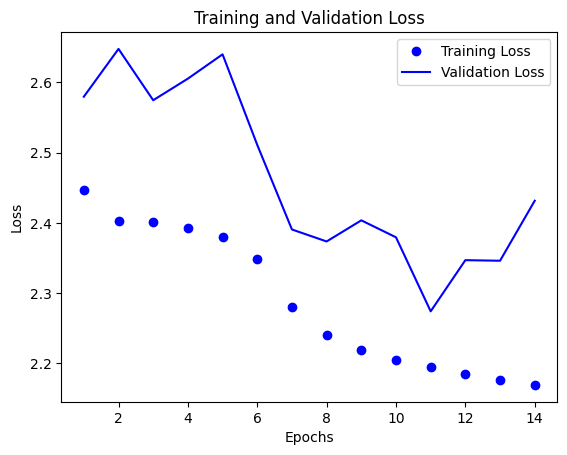

In [49]:
# prompt: plot loss vs val loss

import matplotlib.pyplot as plt

loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

# Create the plot
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [53]:

model_save_path = '/content/drive/My Drive/Colab Notebooks/Data/model1024.keras'



In [57]:

from google.colab import files
files.download('/content/Drive/model1024.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [58]:
files.download('/content/Drive/model1024.keras')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [54]:
model.save('/content/Drive/model1024.h5')


In [59]:
encoder_model = Model(encoder_inputs, encoder_states)
encoder_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, None, 400)      │      1,819,600 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ [(None, 2048), (None,  │     11,673,600 │ embedding_2[0][0]      │
│ (Bidirectional)           │ 1024), (None, 1024),   │                │                        │
│                           │ (None, 1024), (None,   │                │                        │
│                           │ 1024)]                 │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 2048)           │              0 │ bidirectional_1[0][1], │
│ (Concatenate)             │                        │                │ bidirectional_1[0][3]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 2048)           │              0 │ bidirectional_1[0][2], │
│ (Concatenate)             │                        │                │ bidirectional_1[0][4]  │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 13,493,200 (51.47 MB)

 Trainable params: 13,493,200 (51.47 MB)

 Non-trainable params: 0 (0.00 B)

In [64]:
#Create sampling model
decoder_state_input_h  = Input(shape=(2048,))
decoder_state_input_c = Input(shape=(2048,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

final_dex2= dex(decoder_inputs)

decoder_outputs2, state_h2, state_c2 = decoder_lstm(final_dex2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

In [65]:
def sample_with_temperature(preds, temperature=1.0):
    preds = np.log(preds + 1e-10) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    return np.random.choice(len(preds), p=preds)


In [66]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = vocab_to_int['<SOS>']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = sample_with_temperature(output_tokens[0, -1, :], temperature=0.8)
        sampled_char = int_to_vocab[sampled_token_index]
        decoded_sentence += ' '+sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '<EOS>' or
           len(decoded_sentence) > 52):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [67]:
import numpy as np

for i in range(5):
    seq_index = np.random.randint(1, 10)
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', short_answers[seq_index: seq_index + 1])
    print('Decoded sentence:', decoded_sentence)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
-
Input sentence: ["eber's deep conditioner every two days and i never ever use a blowdryer without the diffuser attachment"]
Decoded sentence:  he could we have <EOS>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
-
Input sentence: ['okay then how about we try out some french cuisine saturday night']
Decoded sentence:  get you do an say i have <EOS>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━

In [68]:
def test_sentence(input_sentence):
    # Nettoyage de la phrase d'entrée (si nécessaire)
    input_sentence = clean_text(input_sentence)

    # Convertir la phrase en indices
    input_seq = []
    for word in input_sentence.split():
        if word in vocab_to_int:
            input_seq.append(vocab_to_int[word])
        else:
            input_seq.append(vocab_to_int['<UNK>'])

    input_seq = pad_sequences([input_seq], maxlen=max_line_length, padding='post')

    # Décoder la séquence
    decoded_sentence = decode_sequence(input_seq)
    return decoded_sentence


In [69]:
input_sentence = "Hello"
decoded_sentence = test_sentence(input_sentence)

print(f'Input sentence: "{input_sentence}"')
print(f'Decoded sentence: "{decoded_sentence}"')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Input sentence: "Hello"
Decoded sentence: " i have a bottom freddy <EOS>"


#Loading

In [71]:
from keras.models import load_model
from google.colab import drive
drive.mount('/content/drive')

model = load_model('/content/Drive/model1024.h5')
model.summary()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, None, 400)      │      1,819,600 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_3             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ [(None, 2048), (None,  │     11,673,600 │ embedding_2[0][0]      │
│ (Bidirectional)           │ 1024), (None, 1024),   │                │                        │
│                           │ (None, 1024), (None,   │                │                        │
│                           │ 1024)]                 │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_3 (Embedding)   │ (None, None, 400)      │      1,819,600 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 2048)           │              0 │ bidirectional_1[0][1], │
│ (Concatenate)             │                        │                │ bidirectional_1[0][3]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 2048)           │              0 │ bidirectional_1[0][2], │
│ (Concatenate)             │                        │                │ bidirectional_1[0][4]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ [(None, None, 2048),   │     20,062,208 │ embedding_3[0][0],     │
│                           │ (None, 2048), (None,   │                │ concatenate_2[0][0],   │
│                           │ 2048)]                 │                │ concatenate_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, None, 4549)     │      9,320,901 │ lstm_3[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 44,695,911 (170.50 MB)

 Trainable params: 44,695,909 (170.50 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [83]:
from keras.models import Model
from keras.layers import Input, concatenate

# Récupérer les couches par nom
encoder_inputs = model.input[0]
decoder_inputs = model.input[1]

# Récupérer la couche bidirectionnelle
encoder = model.get_layer("bidirectional_1")
encoder_outputs, state_h_1, state_c_1, state_h_2, state_c_2 = encoder.output

# Concaténer les états
state_h = concatenate([state_h_1, state_h_2], axis=-1)
state_c = concatenate([state_c_1, state_c_2], axis=-1)

# Modèle encodeur
encoder_model = Model(encoder_inputs, [state_h, state_c])

# Construction du modèle décodeur
decoder_state_input_h = Input(shape=(2048,))
decoder_state_input_c = Input(shape=(2048,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# Repasser par l'embedding
decoder_embedding_layer = model.get_layer("embedding_2")
decoder_lstm_input = decoder_embedding_layer(decoder_inputs)

# Repasser par le LSTM
decoder_lstm = model.get_layer("lstm_3")
decoder_outputs, state_h, state_c = decoder_lstm(decoder_lstm_input, initial_state=decoder_states_inputs)

# Dense final
decoder_dense = model.get_layer("dense_1")
decoder_outputs = decoder_dense(decoder_outputs)

# Modèle décodeur
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + [state_h, state_c]
)


In [84]:
def decode_sequence(input_seq):
    # Encoder la séquence d'entrée en utilisant l'encodeur
    states_value = encoder_model.predict(input_seq)

    # Initialiser la séquence cible avec le token <SOS>
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = vocab_to_int['<SOS>']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        # Prédire la sortie du décodeur
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sélectionner un token à partir des probabilités avec sampling
        sampled_token_index = sample_with_temperature(output_tokens[0, -1, :], temperature=0.8)

        if sampled_token_index in int_to_vocab:

          sampled_char = int_to_vocab[sampled_token_index]
          decoded_sentence += ' ' + sampled_char

        else:
            sampled_char = '<UNK>'
            decoded_sentence += ' ' + sampled_char

        # Condition d'arrêt : soit <EOS> soit la longueur maximale
        if sampled_char == '<EOS>' or len(decoded_sentence) > 52:
            stop_condition = True

        # Mettre à jour la séquence cible
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Mettre à jour les états
        states_value = [h, c]

    return decoded_sentence


In [85]:
def clean_text(text):
    '''Clean text by removing unnecessary characters and altering the format of words.'''

    text = text.lower()

    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "that is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"how's", "how is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"n'", "ng", text)
    text = re.sub(r"'bout", "about", text)
    text = re.sub(r"'til", "until", text)
    text = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", text)
    text = " ".join(text.split())
    return text

In [86]:
def test_sentence(input_sentence):
    # Nettoyer la phrase d'entrée (si nécessaire)
    input_sentence = clean_text(input_sentence)

    # Convertir la phrase en indices
    input_seq = []
    for word in input_sentence.split():
        if word in vocab_to_int:
            input_seq.append(vocab_to_int[word])
        else:
            input_seq.append(vocab_to_int['<UNK>'])

    input_seq = pad_sequences([input_seq], maxlen=max_line_length, padding='post')

    # Décoder la séquence
    decoded_sentence = decode_sequence(input_seq)
    return decoded_sentence


In [87]:
def sample_with_temperature(preds, temperature=1.0):
    preds = np.log(preds + 1e-10) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    return np.random.choice(len(preds), p=preds)


In [95]:
input_sentence = "she is okay ?"
import re
import pickle
from keras.preprocessing.sequence import pad_sequences
import numpy as np
from keras.models import Model
from keras.layers import Input, concatenate

min_line_length = 2
max_line_length = 20

with open('/content/drive/My Drive/Colab Notebooks/Datavocab_to_int.pkl', 'rb') as f:
    vocab_to_int = pickle.load(f)

if '<UNK>' not in vocab_to_int:
    vocab_to_int['<UNK>'] = len(vocab_to_int)

int_to_vocab = {v_i: v for v, v_i in vocab_to_int.items()}

decoded_sentence = test_sentence(input_sentence)

print(f'Input sentence: "{input_sentence}"')
print(f'Decoded sentence: "{decoded_sentence}"')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Input sentence: "she is okay ?"
Decoded sentence: " that no they <EOS>"
